Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


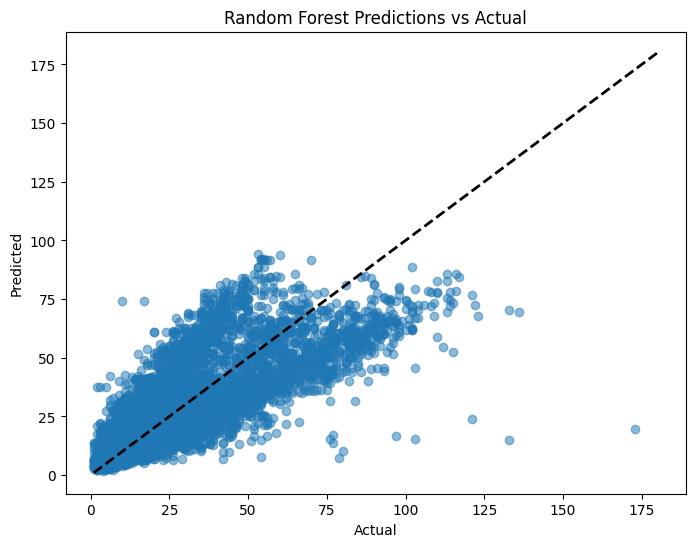

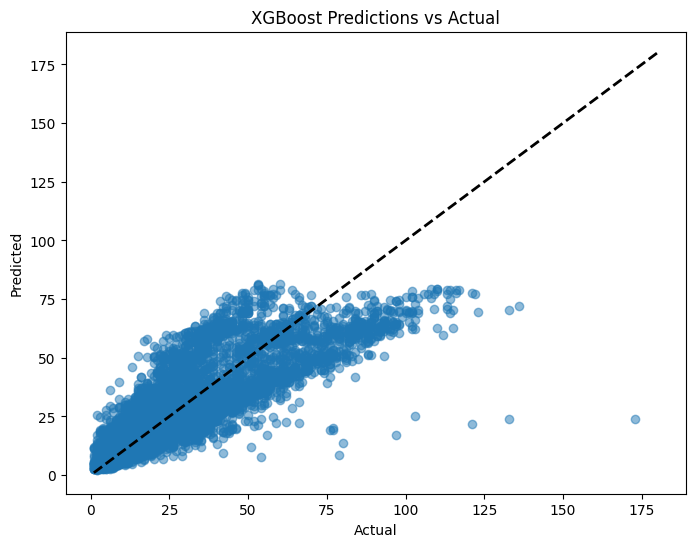

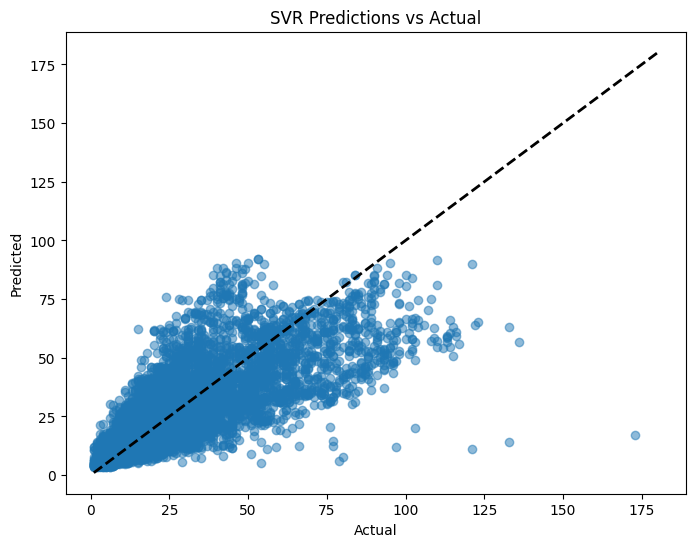

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


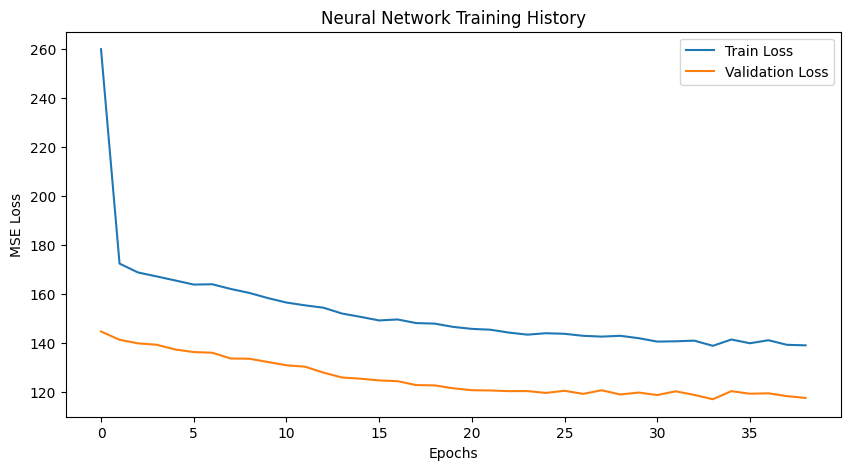

301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


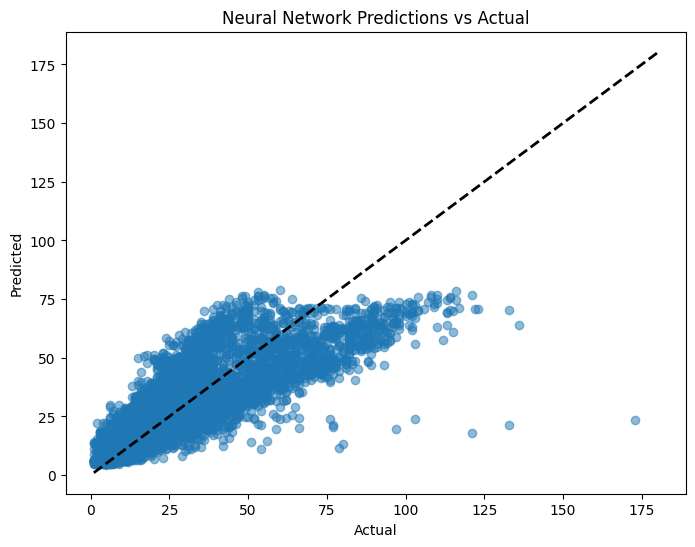

<Figure size 1200x600 with 0 Axes>

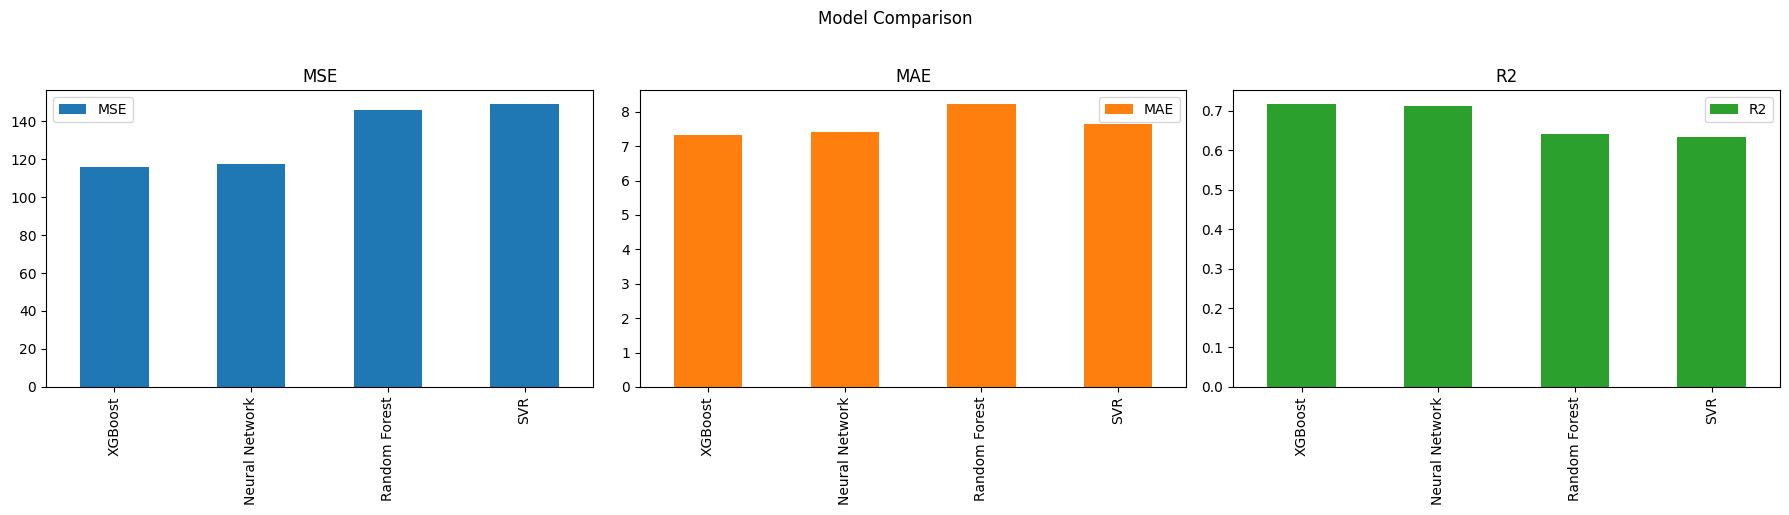


Model Performance Comparison:
                       MSE       MAE        R2
XGBoost         115.608269  7.336823  0.716331
Neural Network  117.651924  7.414100  0.711317
Random Forest   145.969322  8.213299  0.641834
SVR             148.802216  7.658264  0.634883


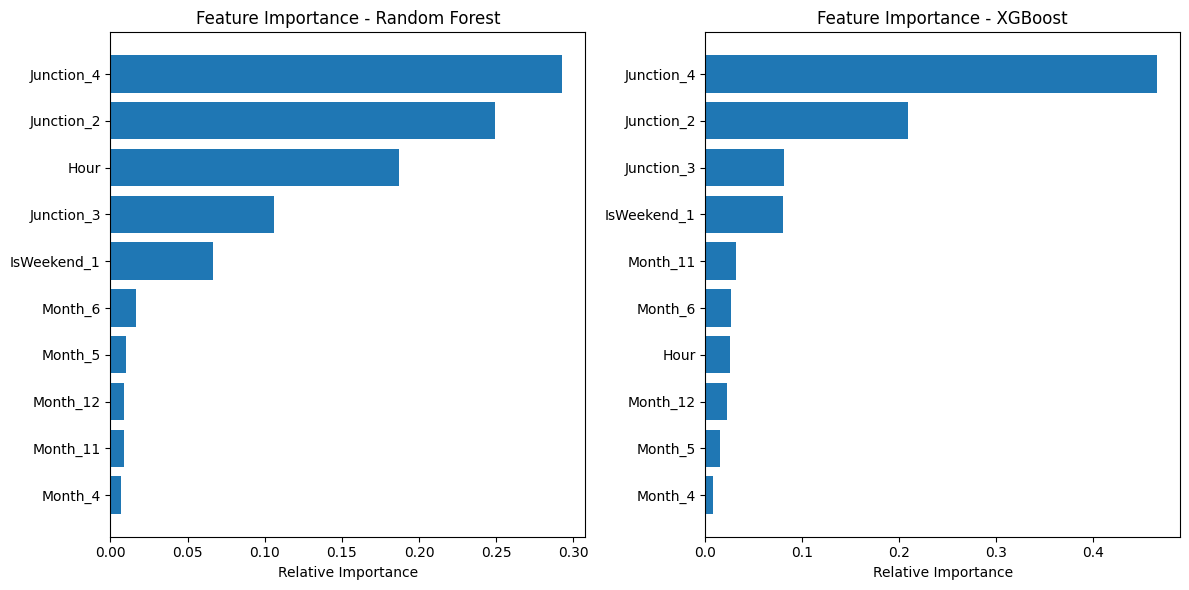

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')


# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/traffic.csv')

# Data Preprocessing
def preprocess_data(df):
    # Convert DateTime and extract features
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Hour'] = df['DateTime'].dt.hour
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek
    df['Month'] = df['DateTime'].dt.month
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    # One-hot encode categorical features
    categorical_cols = ['Junction', 'DayOfWeek', 'Month', 'IsWeekend']
    encoder = OneHotEncoder(drop='first', sparse_output=False)  # Updated parameter
    encoded_cols = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_cols,
                            columns=encoder.get_feature_names_out(categorical_cols))

    # Combine with numerical features
    numerical_cols = ['Hour']
    final_df = pd.concat([df[numerical_cols], encoded_df], axis=1)

    # Target variable
    y = df['Vehicles']

    return final_df, y

# Preprocess the data
X, y = preprocess_data(data)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store model performance
model_results = {}

# Helper function to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Train model
    if 'keras' in str(type(model)):
        history = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=100,
                          batch_size=32,
                          verbose=0,
                          callbacks=[EarlyStopping(patience=5)])

        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{name} Training History')
        plt.xlabel('Epochs')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.show()

        y_pred = model.predict(X_test).flatten()
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    # Plot predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name} Predictions vs Actual')
    plt.show()

    return model

# 1. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model('Random Forest', rf_model, X_train_scaled, y_train, X_test_scaled, y_test)

# 2. XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model('XGBoost', xgb_model, X_train_scaled, y_train, X_test_scaled, y_test)

# 3. Support Vector Regression
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
evaluate_model('SVR', svr_model, X_train_scaled, y_train, X_test_scaled, y_test)

# 4. Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
evaluate_model('Neural Network', nn_model, X_train_scaled, y_train, X_test_scaled, y_test)

# Compare all models
results_df = pd.DataFrame.from_dict(model_results, orient='index')
results_df = results_df.sort_values(by='MSE')

# Plot comparison
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar', subplots=True, layout=(1, 3),
               figsize=(18, 5), sharex=False)
plt.suptitle('Model Comparison', y=1.02)
plt.tight_layout()
plt.show()

# Print results
print("\nModel Performance Comparison:")
print(results_df)

# Feature Importance for tree-based models
plt.figure(figsize=(12, 6))
for i, model in enumerate([rf_model, xgb_model], 1):
    plt.subplot(1, 2, i)
    if i == 1:
        importances = model.feature_importances_
        title = 'Random Forest'
    else:
        importances = model.feature_importances_
        title = 'XGBoost'

    indices = np.argsort(importances)[-10:]  # Top 10 features
    plt.title(f'Feature Importance - {title}')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()